In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

In [2]:
customers = pd.read_csv('DATA\\customers.csv')
geolocation = pd.read_csv('DATA\\geolocation.csv')
order_payments = pd.read_csv('DATA\\order_payments.csv')
order_reviews = pd.read_csv('DATA\\order_reviews.csv')
orders = pd.read_csv('DATA\\orders.csv')
orders_items = pd.read_csv('DATA\\orders_items.csv')
product_category_name_translation = pd.read_csv('DATA\\product_category_name_translation.csv')
products = pd.read_csv('DATA\\products.csv')
sellers = pd.read_csv('DATA\\sellers.csv')

# Данные для обработки

In [3]:
dataset = (
    pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(
                    pd.merge(
                            orders,
                            orders_items,
                            on='order_id'
                            ),
                        products,
                        on='product_id',
                        how='inner'
                        ),
                    product_category_name_translation,
                    on='product_category_name',
                    how='inner'
                    ),
                order_reviews, 
                on='order_id',
                how='inner'
                ),
            customers,
            on='customer_id',
            how='inner'
            )
)

#Рассматриваем только доставленные заказы
dataset = dataset[dataset['order_status'] == 'delivered']

#Количество проданных товаров всех категорий
dataset = pd.merge(
    dataset,
    dataset.groupby('seller_id')['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id': 'total_orders_per_seller'}),
    on='seller_id',
    how='left'
)

#Статистика продаж товаров по категориям и средняя оценка магазина
dataset = pd.merge(
    dataset,
    dataset.groupby(['product_category_name_english', 'seller_id'])
    .agg(
        total_items_sold_by_category=('order_id', 'count'),
        avg_review_score=('review_score', 'mean'))
    .reset_index()
    .rename(columns={'avg_review_score': 'avg_review_score'}),
    on=['product_category_name_english', 'seller_id'],
    how='left'
)

# На случай, если средняя оценка в seller_stats вносит ошибку
# customer_avg_review_score = (
#     dataset.groupby('customer_unique_id')['avg_review_score']
#     .mean()
#     .reset_index()
#     .rename(columns={'avg_review_score': 'avg_review_score_unique'})
# )

# dataset = pd.merge(
#     dataset,
#     customer_avg_review_score,
#     on='customer_unique_id',
#     how='left'
# )

#Характеристики: Количество купленых категорий у конкретного магазина и по всему маркетплейсу
dataset = pd.merge(
    dataset,
    dataset.groupby('customer_unique_id')['product_category_name_english']
    .count()
    .reset_index()
    .rename(columns={'product_category_name_english': 'customer_bying_prudocts_overoll'}),
    on='customer_unique_id',
    how='left'
)

dataset = pd.merge(
    dataset,
    dataset.groupby(['customer_unique_id', 'product_category_name_english'])['seller_id']
    .count()
    .reset_index()
    .rename(columns={'seller_id': 'customer_bying_prudocts_by_seller'}),
    on=['customer_unique_id', 'product_category_name_english'],
    how='left'
)

#Перевод данных в формат даты
dataset['order_purchase_month'] = pd.to_datetime(dataset['order_purchase_timestamp']).dt.to_period('M')

dataset = pd.merge(
    dataset,
    dataset.groupby(['customer_unique_id', 'order_purchase_month'])['order_id']
    .count()
    .reset_index(name='monthly_orders'),
    on='customer_unique_id',
    how='left'
)

#Количество всех предметов покупок на покупателя
dataset = pd.merge(
    dataset,
    dataset.groupby('customer_unique_id')['order_item_id']
           .count()
           .reset_index()
           .rename(columns={'order_item_id': 'total_items_bought'}),
    on='customer_unique_id',
    how='left'
)

#Количество заказов на покупателя
dataset = pd.merge(
    dataset,
    dataset.groupby('customer_unique_id')['order_id']
    .nunique()
    .reset_index()
    .rename(columns={'order_id': 'number_of_orders'}),
    on='customer_unique_id',
    how='left'
)

### матрица корреляций

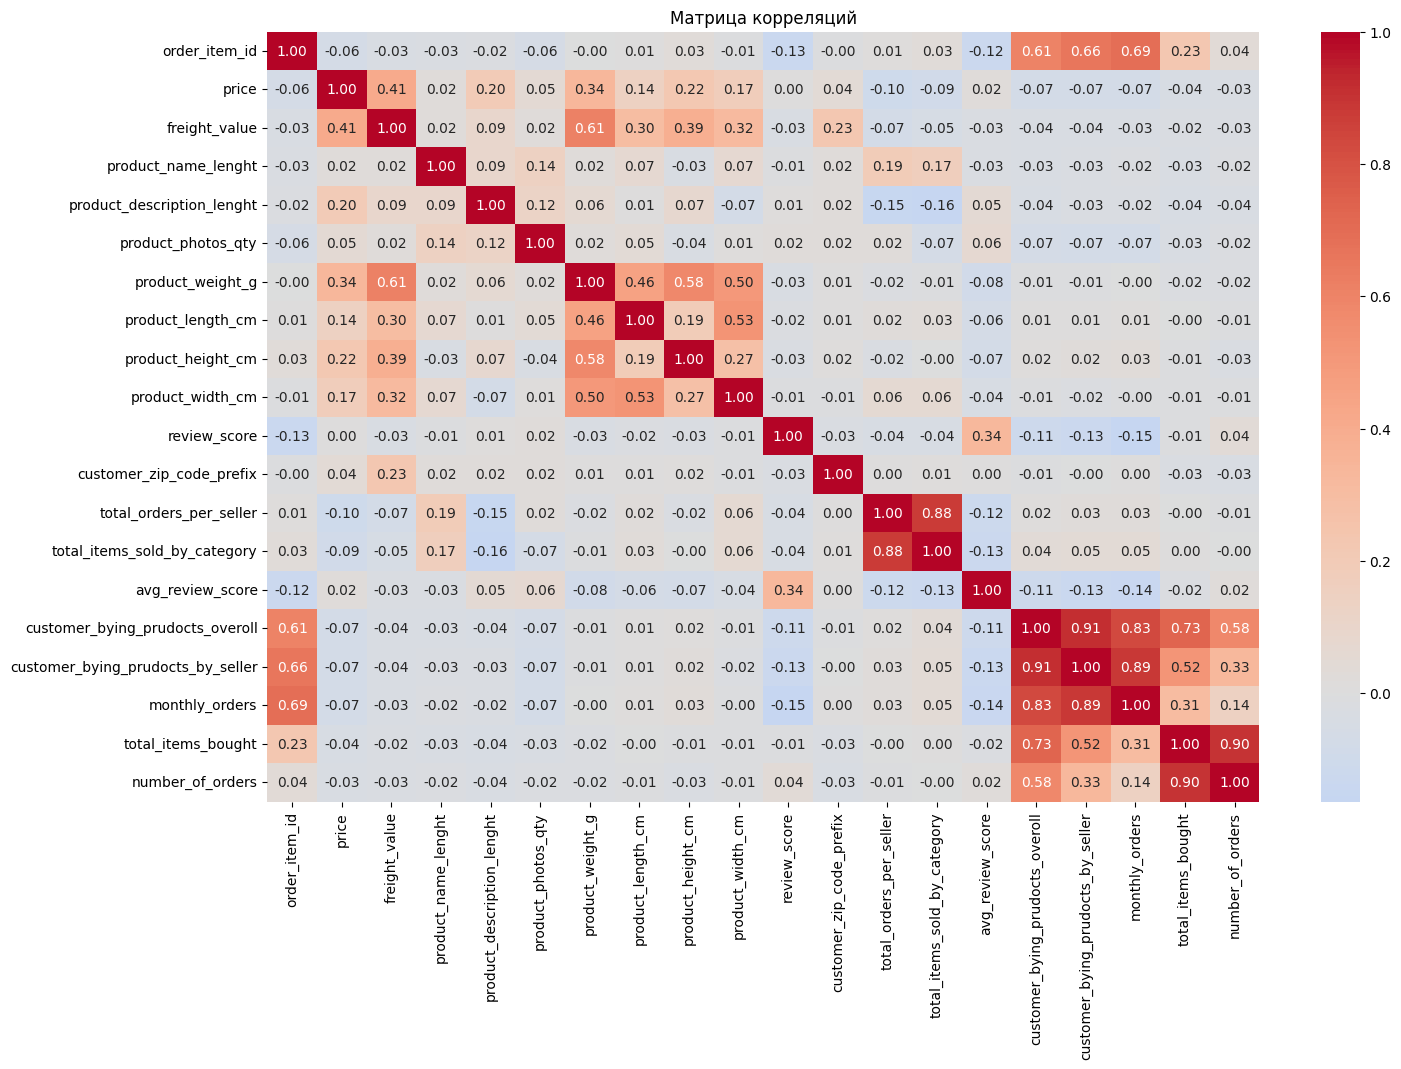

In [4]:
dataset = dataset.drop(['id_x', 'freight_value_3', 'price_2', 'id_y'], axis=1)

corr_matrix = dataset.corr(numeric_only = True)

plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Матрица корреляций")
plt.show()

# Кластеризация покупателей

In [5]:
# Подготовка датасета: разница между заказами
order_dates = (
    dataset[['customer_unique_id', 'order_purchase_timestamp']]
    .drop_duplicates()
    .sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])
)

# Считаем разницу в днях между заказами
order_dates['order_purchase_timestamp'] = pd.to_datetime(order_dates['order_purchase_timestamp'])
order_dates['days_between'] = (
    order_dates.groupby('customer_unique_id')['order_purchase_timestamp']
    .diff().dt.days
)

# Средняя разница между заказами
avg_days = (
    order_dates.groupby('customer_unique_id')['days_between']
    .mean()
    .reset_index()
    .rename(columns={'days_between': 'avg_days_between_orders'})
)

print(order_dates)

                          customer_unique_id order_purchase_timestamp  \
60249   0000366f-3b9a-7992-bf8c-76cfdf3221e2      2018-05-10 10:56:27   
84310   0000b849-f77a-49e4-a4ce-2b2a4ca5be3f      2018-05-07 11:11:27   
30353   0000f46a-3911-fa3c-0805-444483337064      2017-03-10 21:05:03   
112467  0000f6cc-b074-5a6a-4b88-665a16c9f078      2017-10-12 20:29:41   
47508   0004aac8-4e0d-f4da-2b14-7fca70cf8255      2017-11-14 19:45:42   
...                                      ...                      ...   
99272   fffcf5a5-ff07-b090-8bd4-e2dbc735a684      2017-06-08 21:00:36   
23567   fffea47c-d6d3-cc0a-88bd-621562a9d061      2017-12-10 20:07:56   
50179   ffff371b-4d64-5b6e-cea2-44b27531430a      2017-02-07 15:49:16   
110609  ffff5962-728e-c615-7033-ef9805bacc48      2018-05-02 15:17:41   
79867   ffffd265-7e2a-ad29-07e6-7c3e9daecbeb      2017-05-02 20:18:45   

        days_between  
60249            NaN  
84310            NaN  
30353            NaN  
112467           NaN  
47508   

## k-means сегментация

In [6]:
#Признаки: покупатель, сколько купили всего товаров, количество заказов, количество купленых товаров разных категорий
features_kmeans = dataset[[
    'customer_unique_id',
    'total_items_bought',
    'number_of_orders',
    'customer_bying_prudocts_overoll'
]].drop_duplicates()

#Добавляем к признакам среднюю разницу между заказами
features_kmeans = features_kmeans.merge(avg_days, on='customer_unique_id', how='left')

#features_kmeans['avg_days_between_orders'] = features_kmeans['avg_days_between_orders'].fillna(999)

print(features_kmeans.isnull().sum())
print(len(features_kmeans['avg_days_between_orders']))

customer_unique_id                     0
total_items_bought                     0
number_of_orders                       0
customer_bying_prudocts_overoll        0
avg_days_between_orders            89000
dtype: int64
91482


In [7]:
features_kmeans_dates = dataset[[
    'customer_unique_id',
]].drop_duplicates()

features_kmeans_dates = features_kmeans_dates.merge(avg_days, on='customer_unique_id', how='left')
features_kmeans_dates['avg_days_between_orders'] = features_kmeans_dates['avg_days_between_orders']

print(features_kmeans)

                         customer_unique_id  total_items_bought  \
0      7c396fd4-830f-d042-20f7-54e42b4e5bff                   4   
1      af07308b-275d-755c-9edb-36a90c618231                   1   
2      3a653a41-f6f9-fc3d-2a11-3cf8398680e8                   1   
3      7c142cf6-3193-a147-3d2e-66489a9ae977                   1   
4      72632f0f-9dd7-3dfe-e390-c9b22eb56dd6                   1   
...                                     ...                 ...   
91477  6359f309-b166-b019-6dbf-7ad2ac62bb5a                   1   
91478  da62f9e5-7a76-d978-d02a-b5362c509660                   1   
91479  737520a9-aad8-0b3f-bbda-d19b66b37b30                   1   
91480  5097a531-2c8b-157b-b7be-58ae360ef43c                   2   
91481  60350aa9-74b2-6ff1-2caa-d89e55993bd6                   1   

       number_of_orders  customer_bying_prudocts_overoll  \
0                     2                                2   
1                     1                                1   
2              

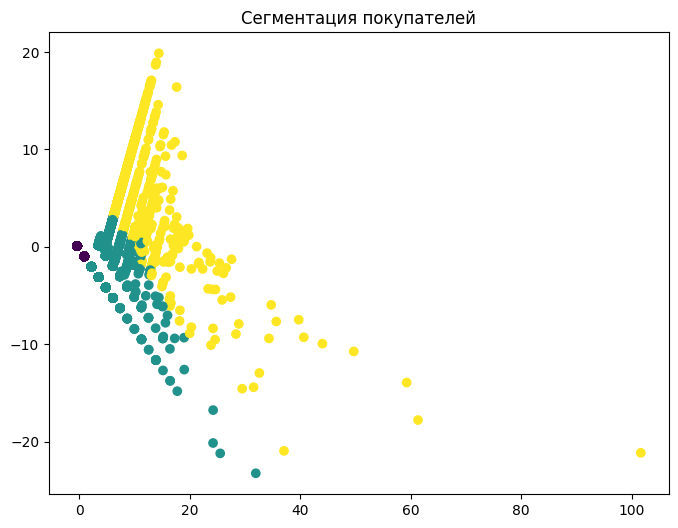

In [8]:
X = features_kmeans.drop('customer_unique_id', axis=1)
X = X.fillna(0)
X_scaled = StandardScaler().fit_transform(X)

X_pca = PCA(n_components=2).fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
features_kmeans['cluster_kmean'] = kmeans.fit_predict(X_scaled)


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=features_kmeans['cluster_kmean'], cmap='viridis')
plt.title('Сегментация покупателей')
plt.show()


In [9]:
features_without_id = features_kmeans.drop(columns=['customer_unique_id'])

cluster_summary = features_without_id.groupby('cluster_kmean').mean()
print(cluster_summary)

               total_items_bought  number_of_orders  \
cluster_kmean                                         
0                        1.077472          1.000000   
1                        3.740274          1.495305   
2                        6.570346          2.256494   

               customer_bying_prudocts_overoll  avg_days_between_orders  
cluster_kmean                                                            
0                                     1.077472                      NaN  
1                                     3.283338                22.166881  
2                                     2.882035               200.140689  


In [10]:
cluster_0_customers = features_kmeans[features_kmeans['cluster_kmean'] == 0]['customer_unique_id']
cluster_1_customers = features_kmeans[features_kmeans['cluster_kmean'] == 1]['customer_unique_id']
cluster_2_customers = features_kmeans[features_kmeans['cluster_kmean'] == 2]['customer_unique_id']

print(f"Не активные клиенты: ", len(cluster_0_customers))

print(f"Покупатели с средней активностью: ", len(cluster_1_customers))

print(f"Покупатели с высокой активностью: ", len(cluster_2_customers))

Не активные клиенты:  86831
Покупатели с средней активностью:  3727
Покупатели с высокой активностью:  924


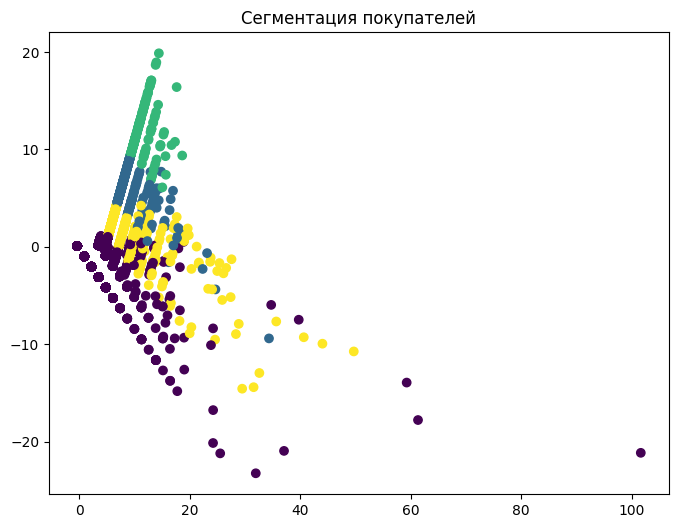

In [11]:
X = features_kmeans_dates.drop('customer_unique_id', axis=1)
X = X.fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# X_pca = PCA(n_components=2).fit_transform(X_scaled)

kmeans = KMeans(n_clusters=4, random_state=42)
features_kmeans_dates['cluster_kmean'] = kmeans.fit_predict(X_scaled)


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=features_kmeans_dates['cluster_kmean'], cmap='viridis')
plt.title('Сегментация покупателей')
plt.show()

In [12]:
cluster_0_customers = features_kmeans_dates[features_kmeans_dates['cluster_kmean'] == 0]
cluster_1_customers = features_kmeans_dates[features_kmeans_dates['cluster_kmean'] == 1]
cluster_2_customers = features_kmeans_dates[features_kmeans_dates['cluster_kmean'] == 2]
#cluster_4_customers = features_kmeans_dates[features_kmeans_dates['cluster_kmean'] == 3]

print(f"Не активные клиенты: ", len(cluster_0_customers))

print(f"Покупатели с средней активностью: ", len(cluster_1_customers))

print(f"Покупатели с высокой активностью: ", len(cluster_2_customers))

#print(f"Покупатели с высокой активностью: ", len(cluster_4_customers))

print(cluster_0_customers)

Не активные клиенты:  90253
Покупатели с средней активностью:  410
Покупатели с высокой активностью:  190
                         customer_unique_id  avg_days_between_orders  \
0      7c396fd4-830f-d042-20f7-54e42b4e5bff                     27.0   
1      af07308b-275d-755c-9edb-36a90c618231                      NaN   
2      3a653a41-f6f9-fc3d-2a11-3cf8398680e8                      NaN   
3      7c142cf6-3193-a147-3d2e-66489a9ae977                      NaN   
4      72632f0f-9dd7-3dfe-e390-c9b22eb56dd6                      NaN   
...                                     ...                      ...   
91477  6359f309-b166-b019-6dbf-7ad2ac62bb5a                      NaN   
91478  da62f9e5-7a76-d978-d02a-b5362c509660                      NaN   
91479  737520a9-aad8-0b3f-bbda-d19b66b37b30                      NaN   
91480  5097a531-2c8b-157b-b7be-58ae360ef43c                      NaN   
91481  60350aa9-74b2-6ff1-2caa-d89e55993bd6                      NaN   

       cluster_kmean  
0     

## HDBSCAN сегментация

In [13]:
features_hdbscan = dataset[[
    'customer_unique_id',
    'total_items_bought',
    'number_of_orders',
    'customer_bying_prudocts_overoll'
]].drop_duplicates()

#Добавляем к признакам среднюю разницу между заказами
features_hdbscan = features_hdbscan.merge(avg_days, on='customer_unique_id', how='left')
features_hdbscan['avg_days_between_orders'] = features_hdbscan['avg_days_between_orders'].fillna(999)

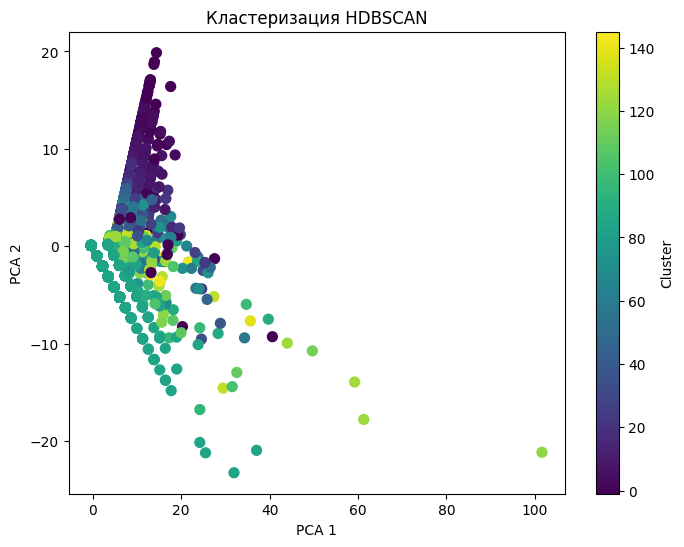

In [14]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5) 

features_hdbscan['cluster_hdbscan'] = clusterer.fit_predict(X_scaled)

# print(X_scaled.shape)
# X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=features_hdbscan['cluster_hdbscan'], cmap='viridis', s=50)
plt.title('Кластеризация HDBSCAN')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

In [15]:
features_without_id = features_hdbscan.drop(columns=['customer_unique_id'])

cluster_summary = features_without_id.groupby('cluster_hdbscan').mean()
print(cluster_summary)

                 total_items_bought  number_of_orders  \
cluster_hdbscan                                         
-1                         5.598361          2.139344   
 0                         4.000000          2.000000   
 1                         4.875000          2.000000   
 2                         5.000000          2.000000   
 3                         5.111111          2.111111   
...                             ...               ...   
 141                       5.142857          2.000000   
 142                       7.428571          2.142857   
 143                       6.666667          2.222222   
 144                       5.000000          2.166667   
 145                       5.272727          2.272727   

                 customer_bying_prudocts_overoll  avg_days_between_orders  
cluster_hdbscan                                                            
-1                                      2.549180               216.300546  
 0                            

### Сравнение k-means и HDBSCAN кластеров

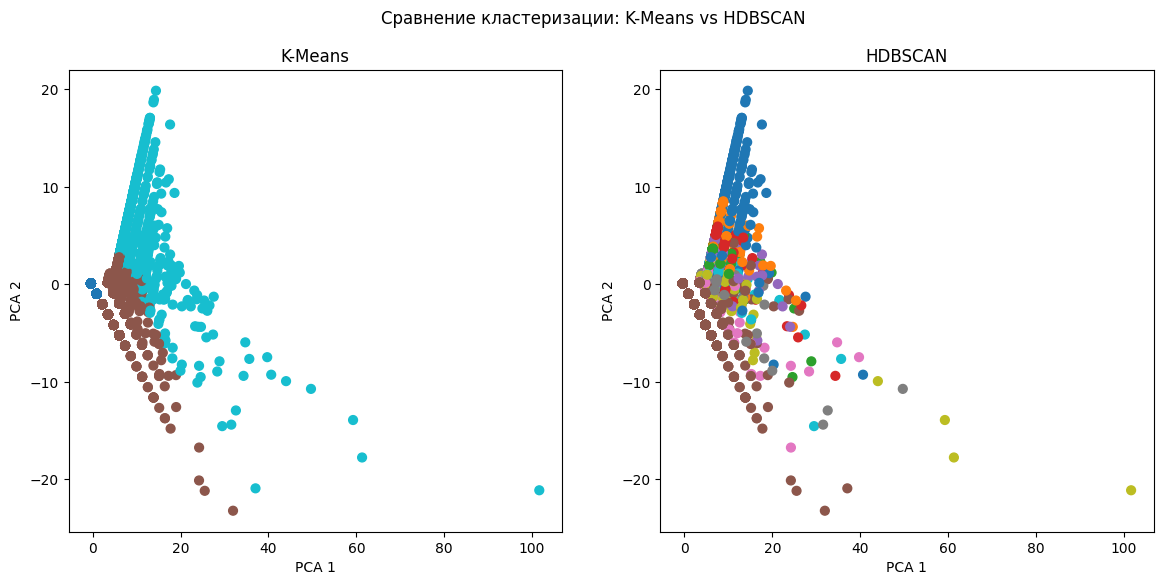

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# KMeans
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=features_kmeans['cluster_kmean'], cmap='tab10', s=40)
axs[0].set_title('K-Means')

# HDBSCAN
axs[1].scatter(X_pca[:, 0], X_pca[:, 1], c=features_hdbscan['cluster_hdbscan'], cmap='tab10', s=40)
axs[1].set_title('HDBSCAN')

for ax in axs:
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')

plt.suptitle('Сравнение кластеризации: K-Means vs HDBSCAN')
plt.show()


In [17]:
from sklearn.metrics import silhouette_score

mask = features_hdbscan['cluster_hdbscan'] != -1

s_kmeans = silhouette_score(X_scaled, features_kmeans['cluster_kmean'])
s_hdbscan = silhouette_score(X_scaled[mask], features_hdbscan['cluster_hdbscan'][mask])

print(f"Silhouette Score (KMeans): {s_kmeans:.3f}")
print(f"Silhouette Score (HDBSCAN): {s_hdbscan:.3f}")


Silhouette Score (KMeans): 0.921
Silhouette Score (HDBSCAN): 0.996


In [18]:
# Пример: сравним средние значения по кластерам
kmeans_summary = features_kmeans.groupby('cluster_kmean').mean(numeric_only=True)
hdbscan_summary = features_hdbscan[features_hdbscan['cluster_hdbscan'] != -1].groupby('cluster_hdbscan').mean(numeric_only=True)

# print("KMeans Summary:")
# print(kmeans_summary)

print("\nHDBSCAN Summary:")
print(hdbscan_summary)


HDBSCAN Summary:
                 total_items_bought  number_of_orders  \
cluster_hdbscan                                         
0                          4.000000          2.000000   
1                          4.875000          2.000000   
2                          5.000000          2.000000   
3                          5.111111          2.111111   
4                          5.076923          2.000000   
...                             ...               ...   
141                        5.142857          2.000000   
142                        7.428571          2.142857   
143                        6.666667          2.222222   
144                        5.000000          2.166667   
145                        5.272727          2.272727   

                 customer_bying_prudocts_overoll  avg_days_between_orders  
cluster_hdbscan                                                            
0                                       2.000000               517.833333  
1           

## Ручная сегментация

In [19]:
#Агрегация данных, чтобы избежать поялвений дубликатов customer_unique_id
agg_features = dataset.groupby('customer_unique_id').agg(
    total_items_bought=('total_items_bought', 'max'),
    number_of_orders=('number_of_orders', 'max'),
    customer_bying_prudocts_overoll=('customer_bying_prudocts_overoll', 'max'),
    avg_review_score=('avg_review_score', 'mean')
).reset_index()

features = agg_features[[
    'customer_unique_id',
    'total_items_bought',
    'number_of_orders',
    'customer_bying_prudocts_overoll',
    'avg_review_score'
]].drop_duplicates()

features = features.merge(avg_days, on='customer_unique_id', how='left')
features['avg_days_between_orders'] = features['avg_days_between_orders'].fillna(999)

print(len(features['customer_unique_id']))

91482


<Axes: xlabel='delivery_cluster', ylabel='avg_days_between_orders'>

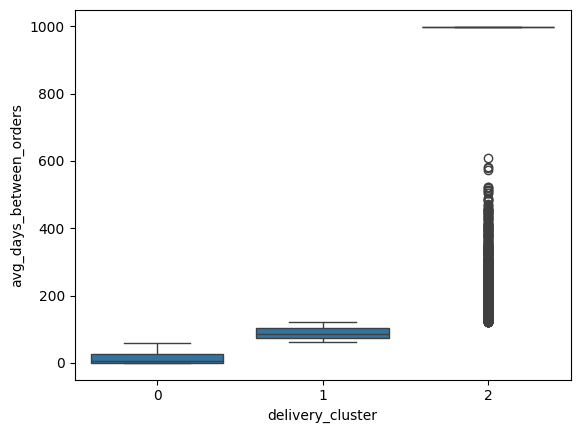

In [20]:
def delivery_cluster(days):
    if days <= 60:
        return 0
    elif days <= 120:
        return 1
    else:
        return 2

features['delivery_cluster'] = features['avg_days_between_orders'].apply(delivery_cluster)

features.groupby('delivery_cluster').mean(numeric_only=True)
sns.boxplot(data=features, x='delivery_cluster', y='avg_days_between_orders')


#### 1109 активных клиентов(совершали последнюю покупку в последние 30 дней). 509 клиентов совершали покупку в течении 90 дней. 165 клиентов покупали последний раз от 3 до 4 месяцев назад. 89699 соверишили последнюю покупку больше полу года назад

In [21]:
cluster_0 = features.groupby('delivery_cluster')['customer_unique_id'].count()[0]
cluster_1 = features.groupby('delivery_cluster')['customer_unique_id'].count()[1]
cluster_2 = features.groupby('delivery_cluster')['customer_unique_id'].count()[2]
# cluster_3 = features.groupby('delivery_cluster')['customer_unique_id'].count()[3]

features.groupby('delivery_cluster')['customer_unique_id'].count()

delivery_cluster
0     1416
1      367
2    89699
Name: customer_unique_id, dtype: int64

### Анализ активности покупателей в зависимости от средней оценки магазина

In [22]:
aboba_customers0 = features[(features['avg_review_score'] < 3) & (features['delivery_cluster' ] == 0)]
aboba_customers1 = features[(features['avg_review_score'] < 3) & (features['delivery_cluster' ] == 1)]
aboba_customers2 = features[(features['avg_review_score'] < 3) & (features['delivery_cluster' ] == 2)]
aboba_customers3 = features[(features['avg_review_score'] < 3) & (features['delivery_cluster' ] == 3)]

print('Процент покупателей из каждой категории активности, которые покупали в магазине с оценкой ниже 3')
print((len(aboba_customers0) / cluster_0) * 100)
print((len(aboba_customers1) / cluster_1) * 100)
print((len(aboba_customers2) / cluster_2) * 100)
# print((len(aboba_customers3) / cluster_3) * 100)

aboba_customers00 = features[(features['avg_review_score'] >= 3) & (features['avg_review_score'] < 4) & (features['delivery_cluster'] == 0)]
aboba_customers11 = features[(features['avg_review_score'] >= 3) & (features['avg_review_score'] < 4) & (features['delivery_cluster'] == 1)]
aboba_customers22 = features[(features['avg_review_score'] >= 3) & (features['avg_review_score'] < 4) & (features['delivery_cluster'] == 2)]
aboba_customers33 = features[(features['avg_review_score'] >= 3) & (features['avg_review_score'] < 4) & (features['delivery_cluster'] == 3)]

print('Процент покупателей из каждой категории активности, которые покупали в магазине с оценкой ниже 4, но не меньше 3')
print((len(aboba_customers00) / cluster_0) * 100)
print((len(aboba_customers11) / cluster_1) * 100)
print((len(aboba_customers22) / cluster_2) * 100)
# print((len(aboba_customers33) / cluster_3) * 100)

aboba_customers000 = features[(features['avg_review_score'] >= 4) & (features['avg_review_score'] < 5) & (features['delivery_cluster'] == 0)]
aboba_customers111 = features[(features['avg_review_score'] >= 4) & (features['avg_review_score'] < 5) & (features['delivery_cluster'] == 1)]
aboba_customers222 = features[(features['avg_review_score'] >= 4) & (features['avg_review_score'] < 5) & (features['delivery_cluster'] == 2)]
aboba_customers333 = features[(features['avg_review_score'] >= 4) & (features['avg_review_score'] < 5) & (features['delivery_cluster'] == 3)]

print('Процент покупателей из каждой категории активности, которые покупали в магазине с оценкой ниже 5, но не меньше 4')
print((len(aboba_customers000) / cluster_0) * 100)
print((len(aboba_customers111) / cluster_1) * 100)
print((len(aboba_customers222) / cluster_2) * 100)
# print((len(aboba_customers333) / cluster_3) * 100)


aboba_customers0000 = features[(features['avg_review_score'] == 5) & (features['delivery_cluster' ] == 0)]
aboba_customers1111 = features[(features['avg_review_score'] == 5) & (features['delivery_cluster' ] == 1)]
aboba_customers2222 = features[(features['avg_review_score'] == 5) & (features['delivery_cluster' ] == 2)]
aboba_customers3333 = features[(features['avg_review_score'] == 5) & (features['delivery_cluster' ] == 3)]

print('Процент покупателей из каждой категории активности, которые покупали в магазине с оценкой 5')
print((len(aboba_customers0000) / cluster_0) * 100)
print((len(aboba_customers1111) / cluster_1) * 100)
print((len(aboba_customers2222) / cluster_2) * 100)
# print((len(aboba_customers3333) / cluster_3) * 100)

Процент покупателей из каждой категории активности, которые покупали в магазине с оценкой ниже 3
0.847457627118644
1.08991825613079
1.6220916621144048
Процент покупателей из каждой категории активности, которые покупали в магазине с оценкой ниже 4, но не меньше 3
35.59322033898305
28.882833787465938
31.17537542224551
Процент покупателей из каждой категории активности, которые покупали в магазине с оценкой ниже 5, но не меньше 4
62.5
70.02724795640327
64.44553450986076
Процент покупателей из каждой категории активности, которые покупали в магазине с оценкой 5
1.059322033898305
0.0
2.7569984057793286


# Анализ кластеров клиентов

In [23]:
active_customers = features.loc[features['delivery_cluster'] == 0, 'customer_unique_id']

potentially_go_away_customers = features.loc[features['delivery_cluster'] == 1, 'customer_unique_id']

go_away_customers = features.loc[features['delivery_cluster'] == 2, 'customer_unique_id']

## Кластеризация продавцов

In [24]:
#Признкаи: общее количество заказов, общее количество проданных товаров, средняя оценка магазина, общее количество продаваемых категорий, средняя цена
seller_features = dataset.groupby('seller_id').agg(
    total_orders=('order_id', 'count'),
    total_items_sold=('order_item_id', 'count'),
    avg_review_score=('review_score', 'mean'),
    total_categories=('product_category_name_english', 'nunique'),
    avg_order_value=('price', 'mean')
).reset_index()

print(seller_features.head())


                              seller_id  total_orders  total_items_sold  \
0  0015a82c-2db0-00af-6aaa-f3ae2ecb0532             3                 3   
1  001cca7a-e9ae-17fb-1cae-d9dfb1094831           235               235   
2  002100f7-78ce-b843-1b7a-1020ff7ab48f            57                57   
3  004c9cd9-d87a-3c30-c522-c48c4fc07416           170               170   
4  00720abe-85ba-0859-8075-95bbf045a33b            34                34   

   avg_review_score  total_categories  avg_order_value  
0          3.666667                 1       895.000000  
1          3.978723                 2       104.808213  
2          4.000000                 1        22.356140  
3          4.147059                 1       115.767176  
4          3.617647                 1        33.088235  


In [25]:
scaler = StandardScaler()
seller_features_scaled = scaler.fit_transform(seller_features[['total_orders', 'total_items_sold', 'avg_review_score', 'total_categories', 'avg_order_value']])

seller_features_scaled_df = pd.DataFrame(seller_features_scaled, columns=['total_orders', 'total_items_sold', 'avg_review_score', 'total_categories', 'avg_order_value'])


In [26]:
kmeans = KMeans(n_clusters=3, random_state=42)
seller_features['cluster'] = kmeans.fit_predict(seller_features_scaled_df)

print(seller_features.head())


                              seller_id  total_orders  total_items_sold  \
0  0015a82c-2db0-00af-6aaa-f3ae2ecb0532             3                 3   
1  001cca7a-e9ae-17fb-1cae-d9dfb1094831           235               235   
2  002100f7-78ce-b843-1b7a-1020ff7ab48f            57                57   
3  004c9cd9-d87a-3c30-c522-c48c4fc07416           170               170   
4  00720abe-85ba-0859-8075-95bbf045a33b            34                34   

   avg_review_score  total_categories  avg_order_value  cluster  
0          3.666667                 1       895.000000        0  
1          3.978723                 2       104.808213        2  
2          4.000000                 1        22.356140        0  
3          4.147059                 1       115.767176        0  
4          3.617647                 1        33.088235        0  


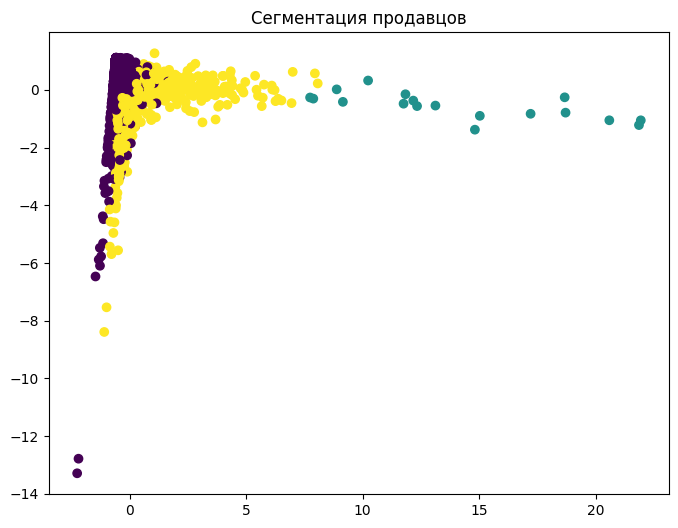

In [27]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(seller_features_scaled_df)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=seller_features['cluster'], cmap='viridis')
plt.title('Сегментация продавцов')
plt.show()


In [28]:
seller_without_id = seller_features.drop(columns=['seller_id'])

print(seller_features.dtypes)
seller_without_id = seller_without_id.groupby('cluster').mean()
print(seller_without_id)

seller_id            object
total_orders          int64
total_items_sold      int64
avg_review_score    float64
total_categories      int64
avg_order_value     float64
cluster               int32
dtype: object
         total_orders  total_items_sold  avg_review_score  total_categories  \
cluster                                                                       
0           14.450490         14.450490          4.481036          1.461275   
1         1319.833333       1319.833333          4.048560          7.000000   
2           71.063604         71.063604          3.397987          3.552415   

         avg_order_value  
cluster                   
0             186.666505  
1              90.876023  
2             149.164186  


In [29]:
seller_0_cluster = seller_features[seller_features['cluster'] == 0]['seller_id']
seller_1_cluster = seller_features[seller_features['cluster'] == 1]['seller_id']
seller_2_cluster = seller_features[seller_features['cluster'] == 2]['seller_id']

print(f"Продавцы с динамикой продаж не для каждой категории покупателей (Мало продают, лучшая средняя оценка, средняя цена на товары выше остальных, количства товаров меньше других): ", len(seller_0_cluster))

print(f"Продавцы, с средней динамикой продаж: ", len(seller_1_cluster))

print(f"Продавцы с худшей динамикой продаж(Средняя оценка ниже, товары дороже, продаж меньше): ", len(seller_2_cluster))

Продавцы с динамикой продаж не для каждой категории покупателей (Мало продают, лучшая средняя оценка, средняя цена на товары выше остальных, количства товаров меньше других):  2040
Продавцы, с средней динамикой продаж:  18
Продавцы с худшей динамикой продаж(Средняя оценка ниже, товары дороже, продаж меньше):  849
